## Time to get your hands dirty.  The transient Universe
### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [1]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from IPython.display import display, Math
import random

In [2]:
#Reading the data
x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
df = x[:,2]

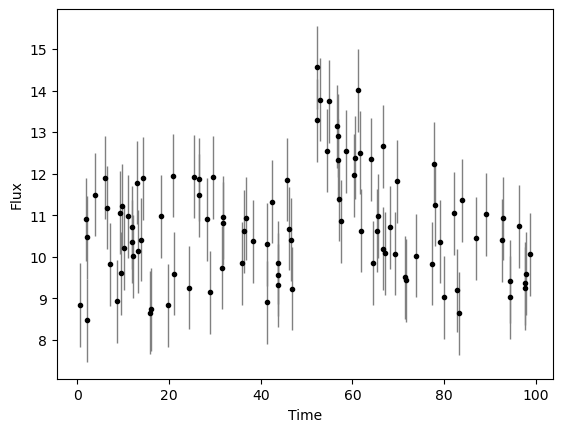

In [3]:
#Plot of the data with uncertanties
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [4]:
#Defining the exponential burst model
def model(time, theta):
    A, b, t0, alpha = theta
    return np.where(time<t0, b, b+A*np.exp(-alpha*(time-t0)))

## Fit by eye

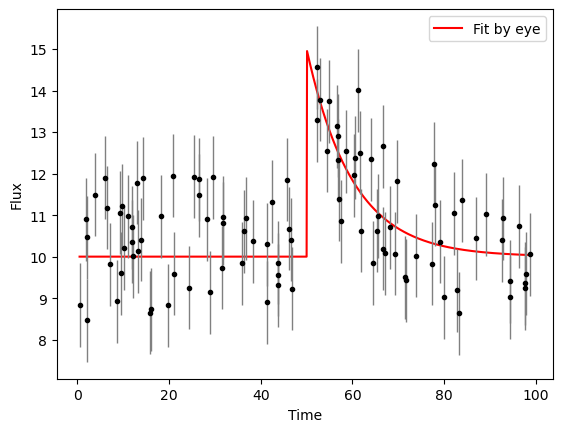

In [5]:
#Fitting the data by guessing the values of the model parameters by eye
A_eye = 5  #Burst amplitude
b_eye = 10  #Background amplitude
t0_eye = 50  #Burst epoch
alpha_eye = 0.1  #How rapidly the burst dies off
theta_eye = [A_eye, b_eye, t0_eye, alpha_eye]

time_grid = np.linspace(time.min(), time.max(), 1000)

plt.plot(time_grid, model(time_grid, theta_eye), color = 'red', label = 'Fit by eye')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

## MCMC using emcee

In [6]:
t0min, t0max = 0, 100
Amin, Amax = 0, 50
bmin, bmax = 0, 50
alphamin, alphamax = np.exp(-5), np.exp(5)

In [7]:
#Definig the log-prior
def Logprior(theta):
    A, b, t0, alpha = theta 
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)  #Using the principle of scale invariance for alpha (the minus comes from 1/alpha)
    return -np.inf

#Defining the log-likelihood
def LogLikelihood(theta, df, flux):
    y_fit = model(time, theta)
    return -0.5 * np.sum((flux-y_fit)**2 / df**2) 

#Defining the log-posterior
def LogPosterior(theta, df, flux):
    return LogLikelihood(theta, df, flux) + Logprior(theta)

In [8]:
ndim = 4  #Dimension of the parameter space
nwalkers = 10  
burn = 10000  #Defining the burn-in
nsteps = 100000  

np.random.seed(42)
starting_guesses = theta_eye + np.random.random((nwalkers, ndim))  #Initial guesses (np.random.random creates a matrix nwalkers x ndim of random numbers
                                                                   #between 0 and 1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[df, flux])  #Defining the sampler
sampler.run_mcmc(starting_guesses, nsteps)  #Running the mcmc

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)  #Defining the trace without burn-in and merging all the samples obtained  the walkers

C:\Users\restu\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


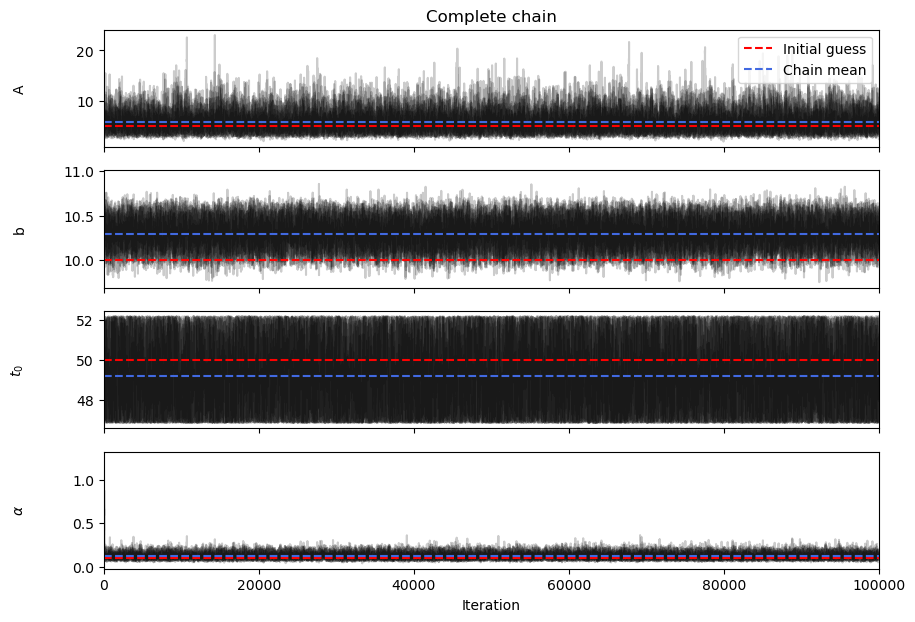

In [9]:
samples = sampler.get_chain()  #Trace with burn-in

#Plotting the traces of all the parameters
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ['A', 'b', r'$t_0$', r'$\alpha$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], color = 'black', alpha=0.2)
    ax.axhline(theta_eye[i], color = 'red', ls = '--', label = 'Initial guess')
    ax.axhline(np.mean(samples[:, :, i]), color = 'royalblue', ls = '--', label='Chain mean')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('Iteration')
axes[0].legend()
axes[0].set_title('Complete chains')
plt.show()

In [10]:
tau = sampler.get_autocorr_time()  #Computing the auto-correlation lengths
thin = tau.astype(int) + 1
print('Autocorrelation times:\n%f, %f, %f, %f' %(tau[0], tau[1], tau[2], tau[3]))

Autocorrelation times:
89.990727, 70.171576, 98.931337, 73.267074


In [11]:
#Thinning the trace using the maximum of the four auto-correlation lengths
burned_trace = sampler.get_chain(discard = 10*max(thin), thin=max(thin), flat=True)  

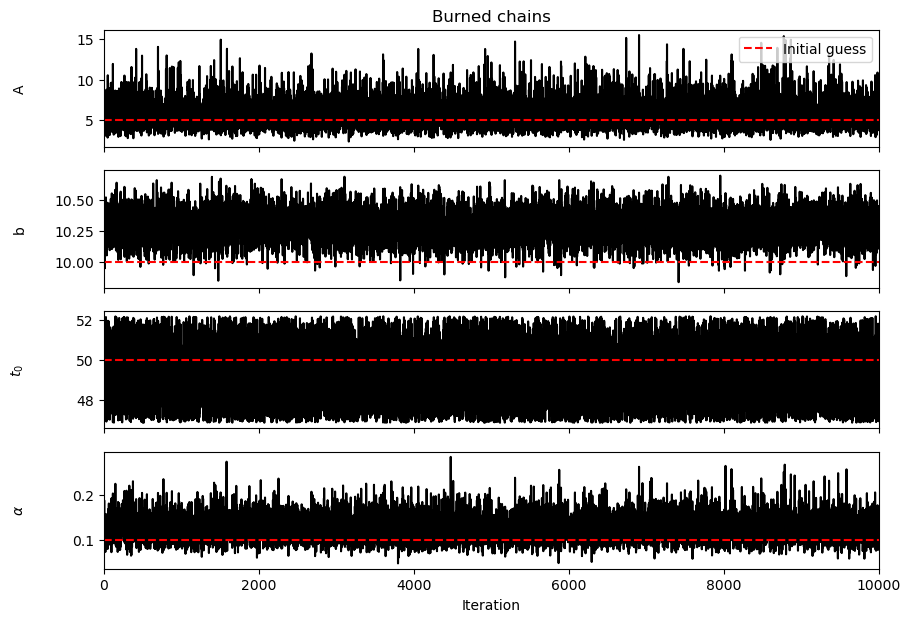

In [33]:
#Plotting the burned and thinned traces 
fig1, axes1 = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes1[i].plot(burned_trace[:,i], color = 'black')
    axes1[i].axhline(theta_eye[i], color = 'red', ls = '--', label = 'Initial guess')
    axes1[i].set_xlim(0, len(burned_trace))
    axes1[i].set_ylabel(labels[i])
    axes1[i].yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel('Iteration')
axes1[0].legend()
axes1[0].set_title('Burned chains')
plt.show()

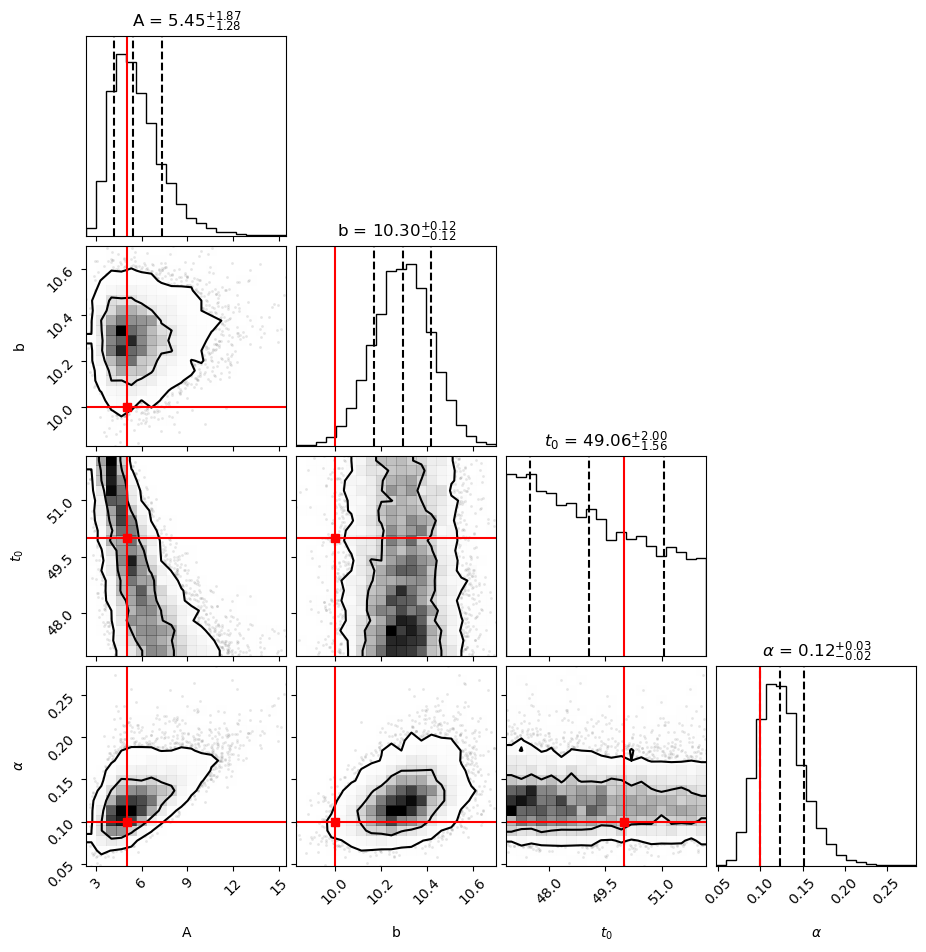

In [35]:
#Corner plot of the parameters highlighting the initial guesses
fig = corner.corner(burned_trace, labels=labels, levels=[0.68,0.95], show_titles=True, 
                    quantiles=[0.16, 0.5, 0.84], truths=theta_eye, truth_color='red'); 

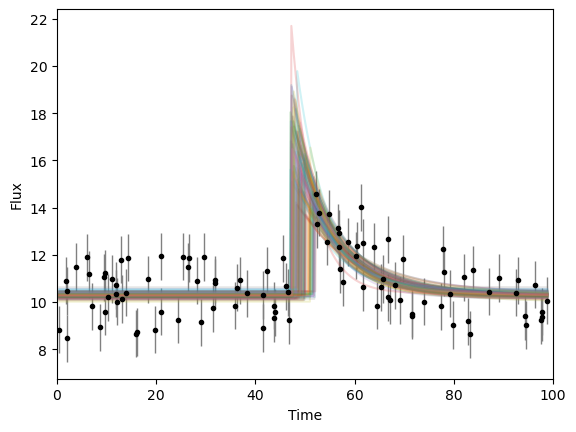

In [36]:
new_sample = np.array(random.sample(burned_trace.tolist(), 100))  #Chossing 100 samples randomly from the burned and thinned trace

plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
[plt.plot(time_grid, model(time_grid, param), alpha=0.2) for param in new_sample]  #Plotting the 100 corresponding burst time-series
plt.xlim(0, len(new_sample))
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()

In [15]:
#Printing the median and the 90% credible region of each parameter
median = []
q = []
perc = []
for i in range(ndim):
    median.append(np.median(burned_trace[:, i]))
    perc.append(np.percentile(burned_trace[:, i], [5, 50, 95]))
    q.append(np.diff(perc[i]))
    name = [r'$A$', r'$b$', r'$\alpha$', r'$t_0$']
    txt = name[i]+r"$ = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
    txt = txt.format(median[i], q[i][0], q[i][1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

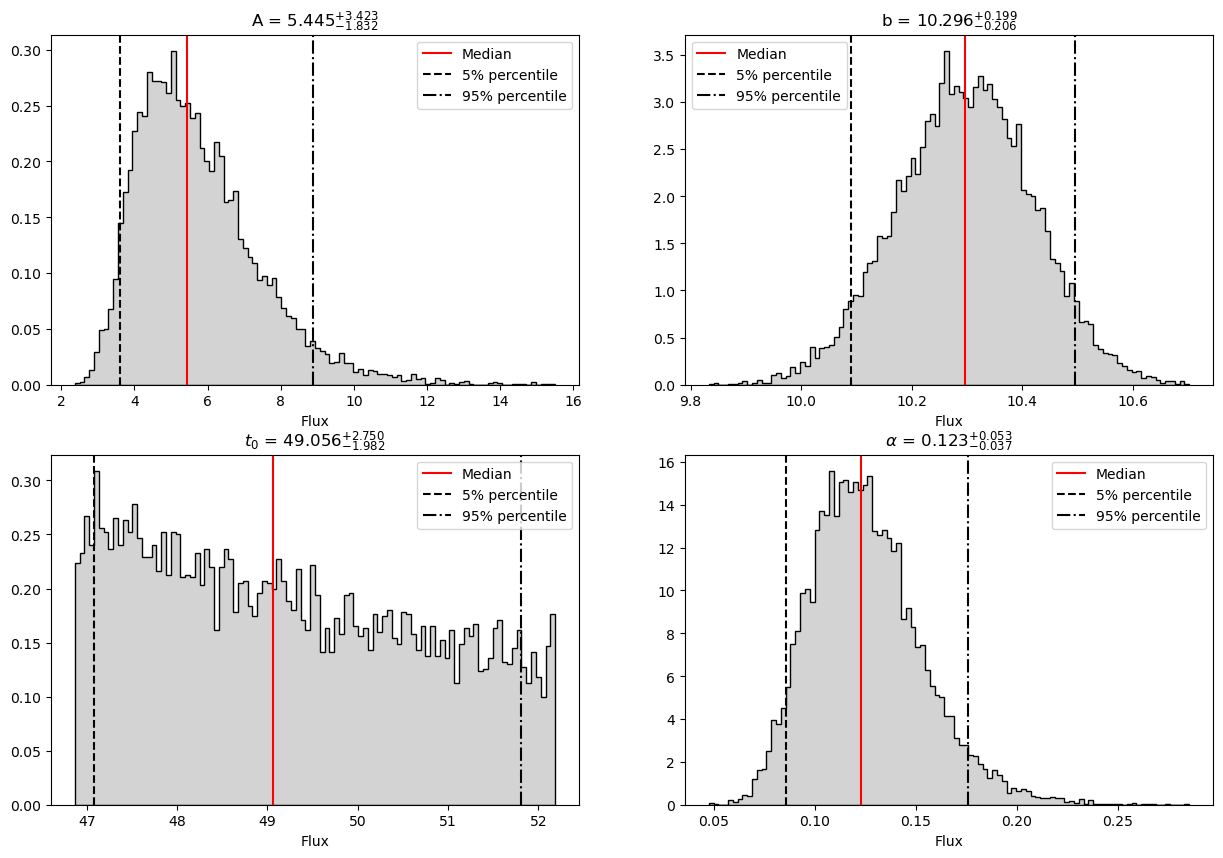

In [16]:
#Plotting the marginalized distribution of each parameter highlighting the median and the 90% credible region
fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10))

k = 0
for i in range(2):
    for j in range (2):
        axs2[i, j].hist(burned_trace[:, k], bins = 100, density = True, ec='black', fc='lightgrey', histtype='stepfilled')
        axs2[i, j].set_xlabel('Flux')
        axs2[i, j].set_title(r'%s = $%0.3f^{+%0.3f}_{-%0.3f}$' %(labels[k], median[k], q[k][1], q[k][0]))
        axs2[i, j].axvline(median[k], color = 'red', label = 'Median')
        axs2[i, j].axvline(perc[k][0], color = 'black', ls = '--', label = '5% percentile')
        axs2[i, j].axvline(perc[k][2], color = 'black', ls = '-.', label = '95% percentile')
        axs2[i, j].legend()
        k += 1

plt.show()

In [17]:
#Finding the MAP
log_probabilities = sampler.get_log_prob(discard = 10*max(thin), thin=max(thin), flat=True)
max_posterior = burned_trace[np.argmax(log_probabilities)]
print('Parameters that maximize the posterior: ', max_posterior)

Parameters that maximize the posterior:  [ 4.04182628 10.27550511 51.49570905  0.11257333]


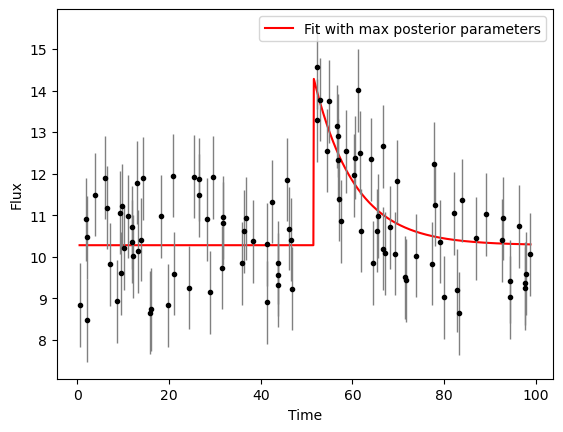

In [18]:
#Fitting our data using the MAP
plt.plot(time_grid, model(time_grid, max_posterior), color = 'red', label = 'Fit with max posterior parameters')
plt.errorbar(time, flux, df, fmt='.k', lw=1, ecolor='gray')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

We cannot use the medians because they don't correspond to a model, since they don't live in the four dimensional space.